Opis problemu
============
Problem pochodzi z [konkursu](https://discuss.analyticsvidhya.com/t/hackathon-3-x-predict-customer-worth-for-happy-customer-bank/3802)


Średniej wielkości bank w Indiach zajmujący się pożyczkami u indywidualnych klientów posiada platformę internetową do udzielania kredytów. Bank pozyskuje wielu klientów poprzez kampanie reklamowe, spamowanie poczty, telemarketing.
Tysiące klientów przekłada się na mały procent udzielanych kredytów. Celem modelu będzie klasyfikacja klienta na podstawie wypełnionego formularza czy zostanie mu przydzielony kredyt. Klient najpierw wypełnia formularz internetowy podając swoje dane osobowe oraz wysokość kwotę o jaką się ubiega. Następnie bank wysyła swoją propozycję spłaty kredytu, która może pokrywać się z deklaracjami klienta. Kolejnymi etapami są dostarczenie dokumentów do oddziału, zalogowanie klienta w systemie. Następnie bank ostanie podejmuje decyzje o udzieleniu kredytu.

Dane wejściowe:
* **ID** -identyfikator klienta (nieużywany do predykcji)
* **Gender**- płeć
* **City**- Miasto
* **Monthly_Income** - przychód miesięczny
* **DOB**- Data urodzenia
* **Lead_Creation_Date** - data złożenia formularza
* **Loan_Amount_Applied** - żądana kwota pożyczki w rupiach
* **Loan_Tenure_Applied** - okres spłaty w latach
* **Existing_EMI** - kwota istniejący pożyczek do spłaty
* **Employer_Name** - nazwa pracodawcy
* **Salary_Account** - nazwa banku konta bankowego
* **Mobile_Verified** - weryfikacja telefoniczna
* **Var5** - Ciągła zmienna klasyfikowana
* **Var1** - Zmienna kategoryczna z wieloma poziomami
* **Loan_Amount_Submitted** - Zmieniona kwota pożyczki po weryfikacji
* **Loan_Tenure_Submitted** - Zmieniony czas spłaty po weryfikacji
* **Interest_Rate** - oprocentowanie pożyczki
* **Processing_Fee** - odsetki w rupiach
* **EMI_Loan_Submitted** - nowa miesięczna spłata
* **Filled_Form** - wypełniony formularz
* **Device_Type** - urządzenie, z którego wysłano formularz (Przeglądarka/Telefon)
* **Var2** - Zmienna kategoryczna z wieloma poziomami
* **Source** - Zmienna kategoryczna z wieloma poziomami
* **Var4** - Zmienna kategoryczna z wieloma poziomami

Dane wyjściowe
* **LoggedIn** - Zalogowanie w aplikacji (zmienna umożliwiająca zrozumienie problemu - nie może być używana w przewidywaniu)
* **Disbursed** - wypłata pożyczki (zmienna tłumacząca)

In [1]:
import pandas as pd
import numpy as np

# wczytuje dane
data = pd.read_csv('HappyCustomerBank.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77020 entries, 0 to 77019
Data columns (total 26 columns):
ID                       77020 non-null object
Gender                   77020 non-null object
City                     76114 non-null object
Monthly_Income           77020 non-null int64
DOB                      77020 non-null object
Lead_Creation_Date       77020 non-null object
Loan_Amount_Applied      76959 non-null float64
Loan_Tenure_Applied      76959 non-null float64
Existing_EMI             76959 non-null float64
Employer_Name            76959 non-null object
Salary_Account           66622 non-null object
Mobile_Verified          77020 non-null object
Var5                     77020 non-null int64
Var1                     77020 non-null object
Loan_Amount_Submitted    46372 non-null float64
Loan_Tenure_Submitted    46372 non-null float64
Interest_Rate            24495 non-null float64
Processing_Fee           24226 non-null float64
EMI_Loan_Submitted       24495 non-null 

In [2]:
# wycinek danych
data.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID079827H20,Male,Agra,34500,05-Dec-79,02-Jul-15,500000.0,4.0,0.0,AIR TREATMENT ENGINEERING PVT LTD,...,13.99,2500.0,13660.73,Y,Web-browser,G,S122,5,0,0
1,ID025067D20,Female,Chennai,12000,16-Mar-93,20-May-15,0.0,0.0,0.0,AGS HEALTH PVT LTD,...,NaN,NaN,NaN,N,Mobile,C,S133,1,0,0
2,ID047181R10,Female,Delhi,47000,10-Oct-57,07-Jun-15,500000.0,5.0,36000.0,GOVERMENT SCHOOL,...,NaN,NaN,NaN,N,Web-browser,B,S133,1,0,0
3,ID096476Q10,Female,Bhiwani,40000,01-Jun-84,14-Jul-15,1000000.0,5.0,3500.0,JABONG.COM,...,NaN,NaN,NaN,N,Web-browser,G,S122,3,0,0
4,ID080804W40,Female,Gurgaon,37491,09-Feb-84,03-Jul-15,0.0,0.0,0.0,APCO INFRA TECH LTD,...,NaN,NaN,NaN,N,Mobile,G,S122,3,0,0


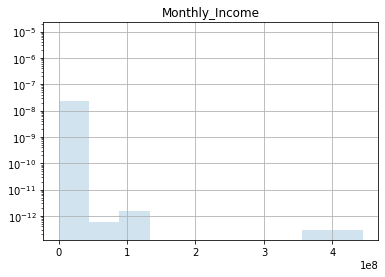

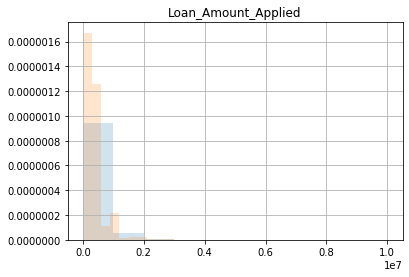

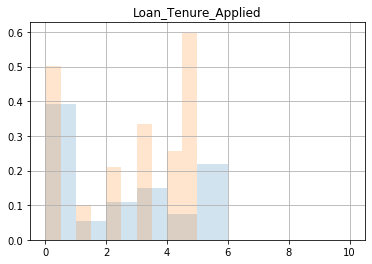

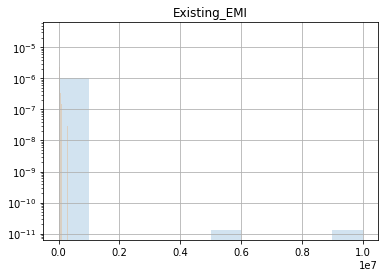

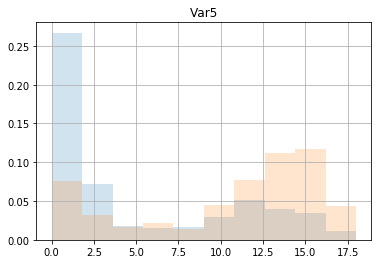

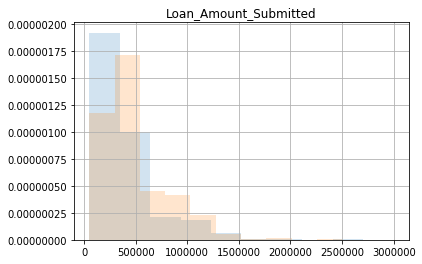

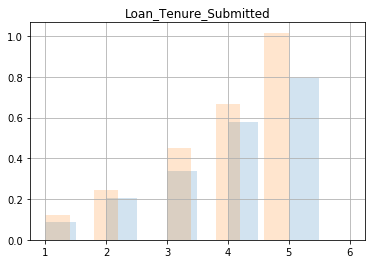

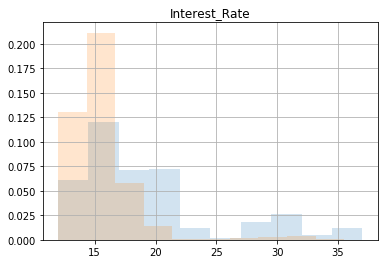

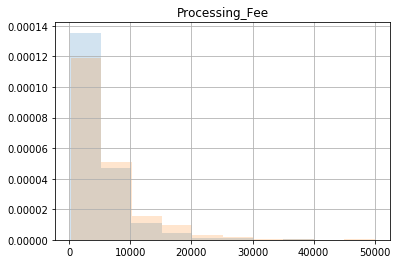

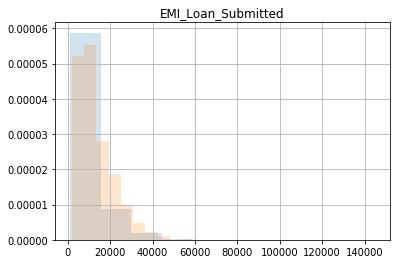

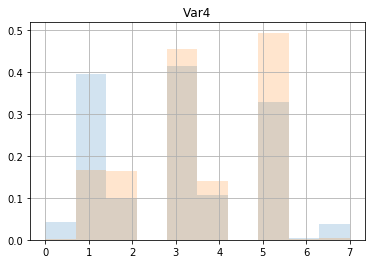

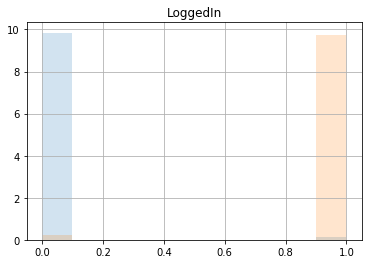

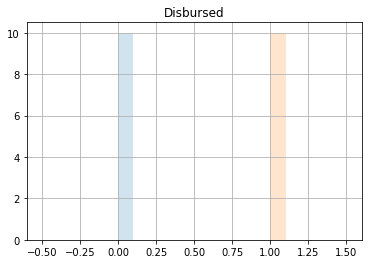

In [6]:
import pylab as plt

# histogramy zmiennych, pogrupowanych względem z zmiennej `Disbursed` 

column_names = data.select_dtypes(exclude=['object']).columns
for column in column_names:
    fig, axs = plt.subplots(ncols=1)
    logscale = False
    if column in ['Monthly_Income', 'Existing_EMI']:
        logscale = True
    data.groupby("Disbursed")[column].hist(alpha=0.2, ax=axs, density=True, label=column,
                                           log=logscale)
    axs.title.set_text(column)

In [7]:
data.groupby("Disbursed").median()

,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Var4,LoggedIn
Disbursed,,,,,,,,,,,,
0,25000,100000.0,2.0,0.0,2,300000.0,4.0,18.00,3900.0,9333.70,3,0
1,49000,250000.0,3.0,0.0,12,400000.0,4.0,14.85,4000.0,11183.06,3,1


Analiza danych
=======
Z wartości środkowych ciężko jest wysnuć jakieś ciekawe spostrzeżenia, na pewno osoby mające większy dochód miesięczny mają większy szanse na otrzymanie kredytu.

Powyżej przedstawiam także rozkłady zmiennych liczbowych, pogrupowanych względem danej wyjściowej.
Niebieskie rozkłady przyporządkowane są klientom, którym odmówiono udzielenie kredytu. Rozkłady zmiennej `Var5` różnią się znacząco, niestety nie jest dokładnie powiedziane, co przedstawia ta zmienna.



Przetwarzanie danych
=============
Posiadamy dane 77020 klientów, z czego 1,4% z nich otrzymało pożyczkę.
Mamy do czynienia z niezbalansowaną licznością klas. Dodatkowo kilka zmiennych ma braki danych w ponad 40%.
Zmienne liczbowe z małymi brakami zostaną dopełnione wartością środkową. Natomiast
zmienne liczbowe z dużymi brakami:
`Loan_Amount_Submitted`,
`Loan_Tenure_Submitted`,
`Interest_Rate`,
`Processing_Fee`,
`EMI_Loan_Submitted`. Przekształcimy na zmienne kategoryczne: zwierające brak danych oraz przynależność do przedziału liczbowego.

Dane o miastach zostaną zastąpione populacją danego miasta, braki danych zostaną zastąpione populacją średniego miasta w Indiach. Zmienne przechowujące daty zostaną zmienione na dane liczbowe w latach.
zmienne posiadające dwie kategorie (`Gender`, `Device_Type`,`Mobile_Verified`,`Filled_Form`) zostaną zakodowane na 0,1. Dane o nazwie banku konta bankowego i nazwie pracodawcy zostaną pominięte.


Dodawanie nowych zmiennych
-------------------
Klasa `NewFeatures` dodaje zmienne
* `Lead_Creation_Client_Age` - Na podstawie daty urodzenia i daty złożenia wniosku tworzę zmienną liczbową. Oznaczająca wiek klienta składającego wniosek w latach.
* `Loan_Eqeuality` - Zmienna bool ma wartość `True` jeżeli proponowana kwota kredytu jest równa kwocie kredytu wnioskowanej przez klienta.

Dla zmiennych typu object o wielu kategoriach `Var1`,`Var2`,`Source` mało popularne wartości zmienia na `other`.

Zmienne liczbowe
`Loan_Amount_Submitted`,
`Loan_Tenure_Submitted`,
`Interest_Rate`,
`Processing_Fee`,
`EMI_Loan_Submitted` przekształcamy na zmienne kategoryczne. Konkretną liczbę kodujemy na odpowiedni kwartyl `Q1`,`Q2`,`Q3`,`Q4` lub  wartość `M` oznaczającą brak danych. 


In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split

import numpy as np
import datetime
import json


# features engering
class NewFeatures(BaseEstimator, TransformerMixin):
    """
    Class crete new features, drop useless column, encodes features.
    """

    def __init__(self, date_format="%d-%b-%y"):
        self.date_format = date_format
        self.DATE = datetime.datetime(2040, 1, 1)
        self.threshold = 0.1  # próg odrzucenia wartości zmiennych katygorycznych z małym prawdopodobieństwem
        super().__init__()

    def transform(self, X):
        def date2float(date_str):
            """
            diff from *date_str* to 2040.01.01 in years.
            """
            _date = datetime.datetime.strptime(date_str, self.date_format)
            if _date.year > self.DATE.year:
                _date = _date.replace(year=_date.year - 100)
            return (self.DATE - _date).days / 365.0

        vdate2float = np.vectorize(date2float)
        # dodaje nową zmieną 'Lead_Creation_Client_Age' wiek kilenta ubiegającego się o kredyt w (latach)
        X['Lead_Creation_Client_Age'] = vdate2float(X['DOB']) - vdate2float(X['Lead_Creation_Date'])

        # dodaje nową zmieną 'Loan_Eqeuality' oznaczającą klientowi zaproponowano
        # kwote, o którą się ubiegał
        X['Loan_Eqeuality'] = data['Loan_Amount_Submitted'] == data['Loan_Amount_Applied']

        # wyrzucam niepotzrbne dane
        X.drop(['DOB', 'Lead_Creation_Date', 'ID', 'LoggedIn', 'Disbursed', 'Employer_Name',
                'Salary_Account'],
               axis=1, inplace=True)
        self.columns = X.columns.tolist()

        return X

    def fit(self, X, y=None):
        # wartości katygoryczne dla zmiennych 'Var1','Var2','Source', których czestość jest mniejsz niż 10%
        # zostają zakodowane jako 'other', ma to na celu finalnie zmniejszenie liczy zmiennych
        for feature in ['Var1', 'Var2', 'Source']:
            value_counts = X[feature].value_counts(normalize=True)  # Specific column 
            to_remove = value_counts[value_counts <= self.threshold].index
            X[feature].replace(to_remove, 'other', inplace=True)

        # Koduje zmnienne liczboiwe do 5 koszyków, przynależność do jednego z qwartylów lub bark danych
        self.quantilies = X.quantile([0.25, 0.5, 0.75])
        for feature in ['Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
                        'Processing_Fee', 'EMI_Loan_Submitted', ]:
            def quantile_code(x):
                if np.isnan(x):
                    return 'M'
                if x <= self.quantilies[feature].iloc[0]:
                    return 'Q1'
                if x <= self.quantilies[feature].iloc[1]:
                    return 'Q2'
                if x <= self.quantilies[feature].iloc[2]:
                    return 'Q3'
                else:
                    return 'Q4'

            vquantile_code = np.vectorize(quantile_code)
            X[feature] = vquantile_code(X[feature])
        return self

    def get_feature_names(self):
        return self.columns


all_features = data.columns.tolist()
features_engineering_transformer = NewFeatures()
features_engineering = make_column_transformer(
    (features_engineering_transformer, all_features), )


Klasa `CityInfoTransformer` wczytuje zewnętrzny plik "city_pop.json" z informacją o populacji
w Indyjskich miastach. Następnie zamienia nazwę miasta na ludność w danym mieście. Brak danych lub brak informacji zastępowana jest populacją średniego miasta w Indiach.

In [4]:
class CityInfoTransformer(BaseEstimator, TransformerMixin):
    """
    Trasform City name in city population
    """

    def __init__(self, json_path="city_pop.json"):
        self.json_path = json_path
        super().__init__()
        with open(self.json_path) as json_file:
            self.city_dict = json.load(json_file)

    def transform(self, X):
        def get_info(city_name):
            city_info = self.city_dict.get(city_name)
            if city_info is None:
                city_info = self.city_dict.get('Mean_city')
            return city_info['population']

        vget_info = np.vectorize(get_info)
        return vget_info(X)

    def fit(self, X, y=None):
        self.columns = X.columns.tolist()
        return self
    
    def get_feature_names(self):
        return self.columns

Klasa `CategoricalBinaryTransformer` koduje zmienne kategoryczne dwu wartościowe na 0,1.
Gdzie 1 jest przyporządkowane wartości dla w pierwszym wierszu danych treningowych.

In [5]:
class CategoricalBinaryTransformer(BaseEstimator, TransformerMixin):
    """
    Code categorical binary values on 0,1
    """

    def __init__(self):
        super().__init__()
        self.code_one = None

    def transform(self, X):
        for feature in X:
            X[feature] = X[feature] == self.code_one[feature].iloc[0]
        return X

    def fit(self, X, y=None):
        self.code_one = X.head(1)
        self.columns = X.columns.tolist()
        return self
    
    def get_feature_names(self):
        return self.columns

Tworze dwa transformatory `binary_features`,`city_features`, które dodaje do transformatora kolumn  `preprocessor`.
`preprocessor` dodatkowo wypełnia brakujące wartości zmiennych liczbowych mediana oraz koduje zmienne kategoryczne 
klasą `OneHotEncoder`.

In [22]:
vcity_features = ['City']
city_transformer = make_pipeline(CityInfoTransformer(), StandardScaler())

binary_features = ['Gender', 'Device_Type', 'Mobile_Verified', 'Filled_Form']
binary_transformer = CategoricalBinaryTransformer()

numerical_features = ['Monthly_Income', 'Loan_Amount_Applied', 'Loan_Tenure_Applied',
                      'Existing_EMI', 'Var5', 'Var4', 'Lead_Creation_Client_Age',
                      'Loan_Eqeuality']

categorical_features = ['Loan_Amount_Submitted',
                        'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee',
                        'EMI_Loan_Submitted', 'Var2', 'Source', 'Var1']

numerical_transformer = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('bim', binary_transformer, binary_features),
        ('city', city_transformer, city_features),
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])


Klasa `ColumnTrnsformer` zwraca tablice beznazw zmiennych, aby zachować nazwy kolumn niezbędne do `OneHotEncoder`, używam dodatkowego kroku w pipe line, który przepisuje nazwy zmiennych pomiędzy krokami. Klasa `RecreteDF` zwraca DataFrame z odpowiednimi nazwami kolumn.

In [40]:
class RecreteDF(BaseEstimator, TransformerMixin):
    '''
    Class recrete column names
    '''

    def __init__(self):
        super().__init__()
        self.after_newfeatures_column_names = ['Gender', 'City', 'Monthly_Income',
                                               'Loan_Amount_Applied', 'Loan_Tenure_Applied',
                                               'Existing_EMI', 'Mobile_Verified', 'Var5', 'Var1',
                                               'Loan_Amount_Submitted', 'Loan_Tenure_Submitted',
                                               'Interest_Rate', 'Processing_Fee',
                                               'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type',
                                               'Var2', 'Source', 'Var4', 'Lead_Creation_Client_Age',
                                               'Loan_Eqeuality']
        self.all_columns_names = ['Gender', 'Device_Type', 'Mobile_Verified', 'Filled_Form', 'City',
                                  'Monthly_Income', 'Loan_Amount_Applied', 'Loan_Tenure_Applied',
                                  'Existing_EMI', 'Var5', 'Var4', 'Lead_Creation_Client_Age',
                                  'Loan_Eqeuality', 'Loan_Amount_Submitted_M',
                                  'Loan_Amount_Submitted_Q1',
                                  'Loan_Amount_Submitted_Q2', 'Loan_Amount_Submitted_Q3',
                                  'Loan_Amount_Submitted_Q4', 'Loan_Tenure_Submitted_M',
                                  'Loan_Tenure_Submitted_Q1', 'Loan_Tenure_Submitted_Q2',
                                  'Loan_Tenure_Submitted_Q3', 'Loan_Tenure_Submitted_Q4',
                                  'Interest_Rate_M', 'Interest_Rate_Q1', 'Interest_Rate_Q2',
                                  'Interest_Rate_Q3', 'Interest_Rate_Q4', 'Processing_Fee_M',
                                  'Processing_Fee_Q1', 'Processing_Fee_Q2', 'Processing_Fee_Q3',
                                  'Processing_Fee_Q4', 'EMI_Loan_Submitted_M',
                                  'EMI_Loan_Submitted_Q1', 'EMI_Loan_Submitted_Q2',
                                  'EMI_Loan_Submitted_Q3', 'EMI_Loan_Submitted_Q4', 'Var2_B',
                                  'Var2_C', 'Var2_G', 'Var2_other', 'Source_S122', 'Source_S133',
                                  'Source_other', 'Var1_HBXC', 'Var1_HBXX', 'Var1_other']

    def transform(self, X):
        return pd.DataFrame(data=X, index=np.arange(len(X)),
                            columns=self.after_newfeatures_column_names)

    def fit(self, X, y=None):
        return self


In [32]:
preprocessor_pipe = Pipeline(steps=[('features_engineering',features_engineering),
                       ('recreate', RecreteDF()),                                    
                       ('preprocessor', preprocessor),                                    
                      ])
# preprocessor_pipe.fit(data)

Dziele próbkę na część testową i treningową. Ze względu na niebalansowane klasy używam atrybutu `stratify`, aby rozkład zmiennej `Disbursed` dla dwóch próbek był podobny.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data, data["Disbursed"],
                                                    stratify=data["Disbursed"], test_size=0.2)

Jednym ze sposobów na problem niezbalansowanych klas, jest zmiana progu klasyfikacji estymatorów.
`ThresholdEstimator` jest wrapperem do Estymatorów, gdzie atrybut `threshold` oznacza próg klasyfikacji.
Do klasy dodałem nazwy atrybutów, z których będę korzystał przy optymalizacji parametrów klasyfikatora.
Taka budowa pozwala przekazać wartość prametrów w `GridSearchCV`.

In [79]:
def ThresholdEstimator(estimator_class):
    
    class ThresholdEstimatorClass(estimator_class):
        def __init__(self,threshold=0.5,penalty=None, min_samples_leaf=None, class_weight=None, **kwargs):
            self.threshold = threshold
#             self.penalty = penalty
#             self.min_samples_leaf = min_samples_leaf
#             self.class_weight = class_weight
            super().__init__(**kwargs) 

        def predict(self,data):
            p_probability = super().predict_proba(data)
            return(p_probability[:,1]>self.threshold).astype(int)
        
    return ThresholdEstimatorClass

Testuje modele: `DecisionTreeClassifier`, `LogisticRegression`, `RandomForestClassifier`. Klasa `GridSearchCV` wybierze najlepsze prametry modeli, względem metryki f1(średnia harmoniczna czułości i precyzji). Będe optymalizował wagi klass, próg predykcji, oraz minimalną próbe w liściu dla algorytmów drzewiastych.  

In [42]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

_class_weight = [{0: 0.01, 1: 0.99}, {0: 0.05, 1: 0.95}, 'balanced']
_threshold = [0.5, 0.75, 0.95]
classifiers = [
    (ThresholdEstimator(DecisionTreeClassifier)(), {'classifier__min_samples_leaf': [30, 50, 70],
                                                    'classifier__class_weight': _class_weight,
                                                    'classifier__threshold': _threshold}),
    (RandomForestClassifier(), {'classifier__min_samples_leaf': [30, 50, 70],
                                'classifier__class_weight': _class_weight}),
    (ThresholdEstimator(LogisticRegression)(), {'classifier__penalty': ['l1'],
                                                'classifier__class_weight': _class_weight,
                                                'classifier__threshold': _threshold}),
]

for classifier, param_grid in classifiers:
    pipe = Pipeline(steps=[('preprocessor_pipe', preprocessor_pipe),
                           ('classifier', classifier)])
    gs = GridSearchCV(pipe, param_grid, cv=3, scoring='f1', n_jobs=2)

    gs.fit(X_train, y_train)
    y_pred = gs.predict(X_test)

    column_names = RecreteDF().all_columns_names
    try:
        values = gs.best_estimator_['classifier'].feature_importances_
    except AttributeError:
        values = gs.best_estimator_['classifier'].coef_[0]
    importances = dict(zip(column_names, values))
    important_features = sorted(importances.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
    print([(feature[0], round(feature[1], 2)) for feature in important_features])
    print(gs.best_params_)
    print("model score(F1): %.3f" % gs.score(X_test, y_test))


[('Monthly_Income', 0.5), ('Lead_Creation_Client_Age', 0.14), ('City', 0.07), ('Var5', 0.05), ('Var4', 0.04), ('Existing_EMI', 0.04), ('Loan_Amount_Applied', 0.03), ('Loan_Tenure_Applied', 0.02), ('Interest_Rate_Q2', 0.01), ('Interest_Rate_Q1', 0.01)]
{'classifier__class_weight': {0: 0.01, 1: 0.99}, 'classifier__min_samples_leaf': 30, 'classifier__threshold': 0.95}
model score(F1): 0.054
[('Monthly_Income', 0.3), ('Var5', 0.12), ('Lead_Creation_Client_Age', 0.08), ('Existing_EMI', 0.07), ('City', 0.05), ('Loan_Amount_Submitted_M', 0.05), ('Var4', 0.04), ('Loan_Amount_Applied', 0.03), ('Interest_Rate_Q1', 0.03), ('Loan_Tenure_Applied', 0.02)]
{'classifier__class_weight': 'balanced', 'classifier__min_samples_leaf': 30}
model score(F1): 0.085
[('Existing_EMI', 2.19), ('Mobile_Verified', -1.07), ('Loan_Amount_Submitted_Q4', 0.81), ('Var5', 0.78), ('Interest_Rate_Q1', 0.59), ('Interest_Rate_Q4', -0.58), ('Var2_C', 0.57), ('Loan_Amount_Submitted_M', -0.51), ('Monthly_Income', -0.46), ('Sourc

|  Model |  F1 |
|:-:|:-:|
| Drzewo decyzyjne  | 0.054  |
|  Las losowy | 0.085  |
| Regresja logistyczna  | 0.102  |

Spośród testowanych parametrów, najlepszym modelem okazała się Regresja Logistyczna.
Dla algorytmów drzewiastych najważniejsze zmienne to: Przychód miesięczny, wiek klienta, miasto, istniejące zobowiązania oraz zmienna Var5.

Dla regresji liniowej największy wpływ na model miały zmienne: Istniejące zobowiązania, Weryfikacja telefoniczna, Duża kwota zaproponowanej pożyczki, zmienna Var5, wielkość oprocentowania pożyczki, brak zaproponowanej kwoty kredytu.

Selekcja zmiennych
===================
W kolejnym etapie przeprowadzimy selekcje zmiennych, aby skrócić czas obliczeń, co pozwoli nam uruchomić model liniowy na większej siatce parametrów. Po przetwarzaniu danych otrzymaliśmy 48 zmiennych, wiele z nich ma mały wpływ na model.

In [90]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score

pipe = Pipeline(steps=[('preprocessor_pipe', preprocessor_pipe),
                       ('feature_selection', RFECV(estimator=LogisticRegression(
                           class_weight={0: 0.01, 1: 0.99}, penalty='l1'), step=1,
                           min_features_to_select=5, scoring='f1')),
                       ('classifier', ThresholdEstimator(LogisticRegression)()),
                       ])
parameters_grid = {'classifier__penalty': ['l1', 'l2'],
                   'classifier__class_weight': [{0: 0.01, 1: 0.99}, {0: 0.05, 1: 0.95},
                                                {0: 0.05, 1: 0.995}],
                   'classifier__threshold': [0.65, 0.75, 0.85, 0.77]}
gs = GridSearchCV(pipe, param_grid, cv=8, scoring='f1', n_jobs=2)
gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)
values = gs.best_estimator_['classifier'].coef_[0].round(2)
importances = dict(zip(column_names, values))
important_features = sorted(importances.items(), key=lambda x: abs(x[1]), reverse=True)
print(important_features)
print(gs.best_params_)
print("model score(F1): %.3f" % gs.score(X_test, y_test))
print("model accuracy: %.3f" % accuracy_score(y_test, y_pred))



[('Loan_Tenure_Applied', 2.19), ('Device_Type', -1.06), ('Loan_Amount_Submitted_Q1', 0.8), ('Existing_EMI', 0.78), ('Loan_Amount_Submitted_Q2', -0.73), ('Loan_Tenure_Submitted_Q3', -0.59), ('Loan_Tenure_Submitted_M', 0.58), ('Interest_Rate_Q2', 0.57), ('City', -0.46), ('Processing_Fee_M', -0.4), ('Mobile_Verified', 0.37), ('Loan_Amount_Submitted_Q4', 0.27), ('Interest_Rate_Q4', 0.27), ('Loan_Amount_Applied', 0.26), ('Monthly_Income', -0.25), ('Loan_Amount_Submitted_M', 0.25), ('Gender', 0.23), ('Interest_Rate_Q1', 0.23), ('Loan_Tenure_Submitted_Q2', -0.19), ('Loan_Amount_Submitted_Q3', 0.17), ('Interest_Rate_M', -0.16), ('Var4', 0.15), ('Filled_Form', 0.1), ('Var5', -0.1), ('Loan_Tenure_Submitted_Q1', 0.1), ('Loan_Tenure_Submitted_Q4', 0.08), ('Interest_Rate_Q3', -0.06), ('Lead_Creation_Client_Age', 0.05), ('Loan_Eqeuality', -0.05)]
{'classifier__class_weight': {0: 0.01, 1: 0.99}, 'classifier__penalty': 'l1', 'classifier__threshold': 0.75}
model score(F1): 0.102
model accuracy: 0.899
